In [1]:
import sys
import os
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from scipy.sparse import random
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import scipy.stats as stats
import seaborn

# NOTE: I am ignoring the max iteration warnings for nmf
import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

import sparse_nmf
import diffusion_nmf
import importlib
importlib.reload(sparse_nmf)
importlib.reload(diffusion_nmf)
from sparse_nmf import SparseNMF
from diffusion_nmf import DiffusionNMF

### Testing with Synthetic Data

In [2]:
def gen_data():
    # generates testing data and saves it so I can test in matlab as well
    test_h = random(4,52, density = 0.07).A
    H = pd.DataFrame(test_h)

    x = np.linspace(1,10,300)
    y1 = stats.norm.pdf(x, 5) * 20
    y2 = []
    y3 = []
    y4 = []
    for i in x:
        y2.append((i - 5)**2)
        y3.append(2 * i)
        y4.append((i - 5)**3/10 + 10)
    y4 = np.array(y4)

    W = pd.DataFrame(np.array([y1, y2, y3, y4]).T)

    return W,H

In [3]:
W,H = gen_data()
X = np.dot(W,H)

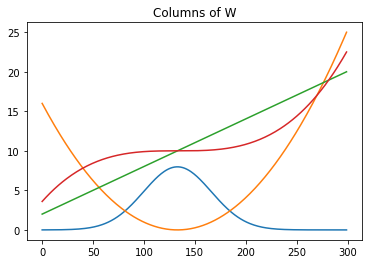

In [4]:
for col in W:
    plt.plot(W.loc[:,col])
    plt.title("Columns of W")

Text(0.5, 1.0, 'Sparse H')

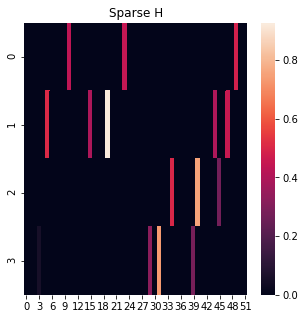

In [5]:
plt.figure(figsize = (5,5))
seaborn.heatmap(H, square = False, cbar = True)
plt.title("Sparse H")

In [6]:
# sparseness of H
h_sparse = 0
for row in H.index:
    rh = np.array(H.loc[row,:])
    sp = math.sqrt(len(rh)) - (sum(np.abs(rh))/ math.sqrt(sum(rh ** 2)))
    sp /= (math.sqrt(len(rh)) - 1)
    h_sparse += sp
    
h_sparse /= len(H.index)
print(h_sparse)
    

0.8759719739486365


In [7]:
# sparseness of W
w_sparse = 0
for col in W.columns:
    cw = np.array(W.loc[:,col])
    sp = math.sqrt(len(cw)) - (sum(np.abs(cw))/ math.sqrt(sum(cw ** 2)))
    sp /= (math.sqrt(len(cw)) - 1)
    w_sparse += sp
    
w_sparse /= len(W.columns)
print(w_sparse)

0.21078519104020454


### Comparing SparseNMF with Sklearn NMF

In [13]:
model = SparseNMF(X, 4, iterations = 500, sH = h_sparse)    
model.solver()
spW = pd.DataFrame(model.W)
spH = pd.DataFrame(model.H)

Text(0.5, 1.0, 'Original columns of W')

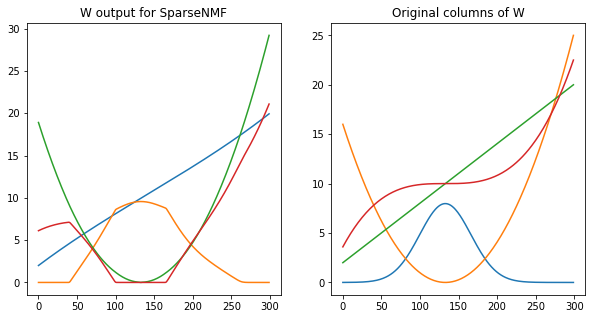

In [14]:
fix, ax = plt.subplots(1, 2, figsize = (10,5))
for col in spW:
    ax[0].plot(spW.loc[:,col])
    ax[1].plot(W.loc[:,col])
    
ax[0].set_title("W output for SparseNMF")
ax[1].set_title("Original columns of W")

Text(0.5, 1.0, 'Original H')

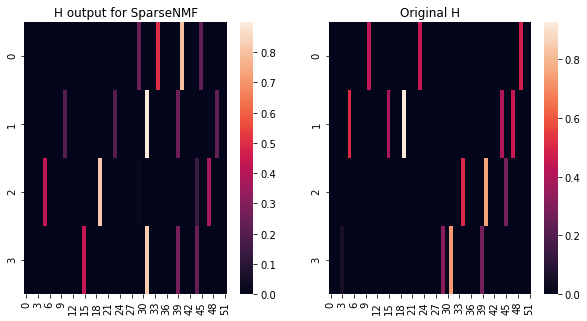

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
seaborn.heatmap(spH, square = False, cbar = True, ax = ax[0])
ax[0].set_title("H output for SparseNMF")
seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Original H")

In [16]:
# ERRors
print("SparseNMF error on W:", np.linalg.norm(W - spW/1.7))
print("SparseNMF error on H:", np.linalg.norm(H - spH))
print("SparseNMF error on X:", np.linalg.norm(X - np.dot(spW, spH)))

SparseNMF error on W: 280.0315015079294
SparseNMF error on H: 2.553180742959677
SparseNMF error on X: 37.97151733649711


In [17]:
model2 = NMF(n_components = 4, init = 'random', random_state = 35, max_iter = 500)
sciW = pd.DataFrame(model2.fit_transform(X))
sciH = pd.DataFrame(model2.components_)

Text(0.5, 1.0, 'Original columns of W')

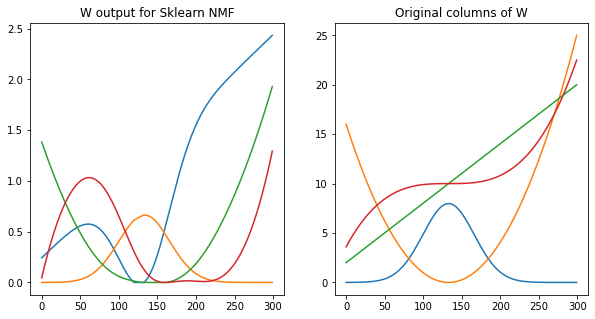

In [18]:
fix, ax = plt.subplots(1, 2, figsize = (10,5))
for col in spW:
    ax[0].plot(sciW.loc[:,col])
    ax[1].plot(W.loc[:,col])
    
ax[0].set_title("W output for Sklearn NMF")
ax[1].set_title("Original columns of W")

Text(0.5, 1.0, 'Original H')

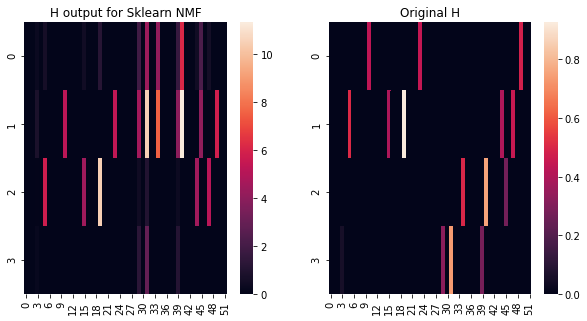

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
seaborn.heatmap(sciH, square = False, cbar = True, ax = ax[0])
ax[0].set_title("H output for Sklearn NMF")
seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Original H")

In [20]:
print("Scipy error on W:", np.linalg.norm(W - sciW))
print("Scipy error on H:", np.linalg.norm(H - sciH))
print("Scipy error on X:", np.linalg.norm(X - np.dot(sciW, sciH)))

Scipy error on W: 332.3964063276997
Scipy error on H: 27.42724112607549
Scipy error on X: 0.49189575189658385


# Diffusion NMF

### Random Laplacian

In [21]:
# Making a synthetic laplacian and corresponding diffusion kernel:
def make_lapl(zero_prob, ones_prob):
    locs = X.shape[1]
    lapl = np.zeros((locs,locs))
    
    for i in range(lapl.shape[0]):
        for j in range(lapl.shape[1]):
            if i == j:
                break
            else:
                lapl[i,j] = -1 * np.random.choice([0,1], p = [zero_prob, ones_prob])
                lapl[j,i] = lapl[i,j]
    
    for i in range(lapl.shape[0]):
        lapl[i,i] = abs(lapl[i].sum())
        
    return lapl

In [22]:
I = np.identity(X.shape[1])

In [23]:
betav = 3
probs = np.flip(np.linspace(0,1,20))
connections = []
cond = []
for prob in probs:
    lapp = make_lapl(prob, 1 - prob)
    
    connections.append(np.trace(lapp))
    
    Kt = np.linalg.inv(I + betav * lapp)
    cond.append(np.linalg.cond(Kt))

Text(0, 0.5, 'Condition number')

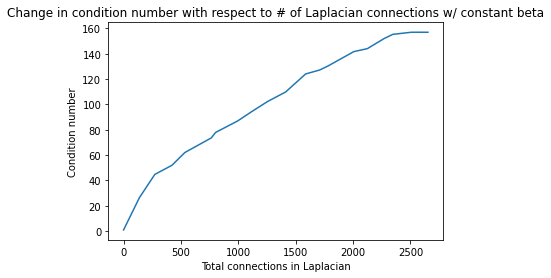

In [24]:
plt.plot(connections, cond)
plt.title("Change in condition number with respect to # of Laplacian connections w/ constant beta")
plt.xlabel("Total connections in Laplacian")
plt.ylabel("Condition number")

In [25]:
lapx = make_lapl(0.7, 0.3)
betas = np.linspace(1,30,30)
cond = []
for b in range(30):
    Kx = np.linalg.inv(I + b * lapx)
    cond.append(np.linalg.cond(Kx))

Text(0, 0.5, 'Condition number')

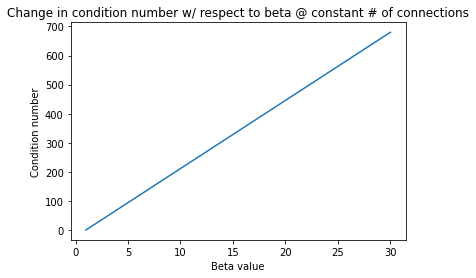

In [26]:
plt.plot(betas, cond)
plt.title("Change in condition number w/ respect to beta @ constant # of connections")
plt.xlabel("Beta value")
plt.ylabel("Condition number")

In [27]:
def diffn_plot(w, h, lap, beta_vals, sparseness = None):
    # plot the diffusion NMF results over a range of beta values
    for beta in beta_vals:
            Kinv = I + beta * lap
            K = np.linalg.inv(Kinv)
                
            D = np.dot(w, np.dot(h, K))
            print("K Condition Number : " + str(np.linalg.cond(K)))

            differ = DiffusionNMF(D, K, ncomponents = 4, sparseV = sparseness, sparseX = None, iterations = 1000, tol = 1e-200)
            differ.solver()
            diffX = pd.DataFrame(differ.X)
            diffV = pd.DataFrame(differ.V)

            fix, ax = plt.subplots(1, 2, figsize = (10,5))
            for col in spW:
                ax[0].plot(diffX.loc[:,col])
                ax[1].plot(w.loc[:,col])

                ax[0].set_title("X output for Diffusion NMF for beta = " + str(beta))
                ax[1].set_title("Original columns of W")
            plt.show()

            fig, ax = plt.subplots(2, 1, figsize = (5,10))
            seaborn.heatmap(diffV, square = False, cbar = True, ax = ax[0])
            ax[0].set_title("V output for Diffusion NMF")
            seaborn.heatmap(h, square = False, cbar = True, ax = ax[1])
            ax[1].set_title("Original H")
            plt.show()

            print("Diffusion X error on W:", np.linalg.norm(w - diffX))
            print("Diffusion V error on H:", np.linalg.norm(h - diffV))
            print("Diffusion error on D:", np.linalg.norm(D - np.dot(diffX, np.dot(diffV, K))))
            print()

In [28]:
L = make_lapl(0.7, 0.3)

In [29]:
np.trace(L)

784.0

K Condition Number : 25.91279651225591


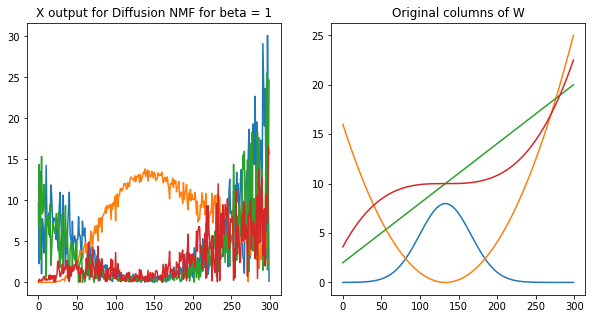

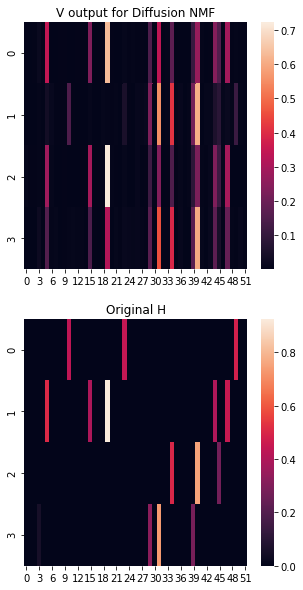

Diffusion X error on W: 309.05787382841413
Diffusion V error on H: 2.5144457731572656
Diffusion error on D: 3.7251895762103047

K Condition Number : 75.7383895367676


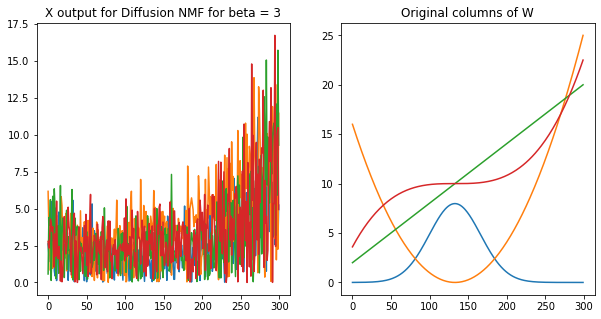

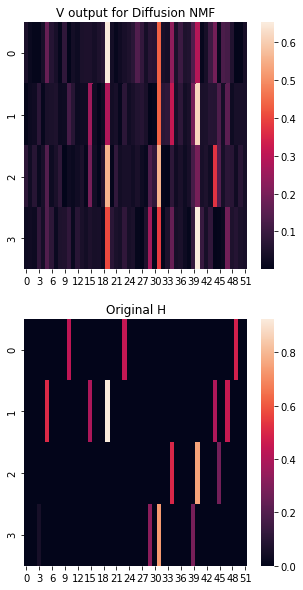

Diffusion X error on W: 254.34029048446703
Diffusion V error on H: 2.372526052089259
Diffusion error on D: 3.9348448354122403

K Condition Number : 250.12796512255878


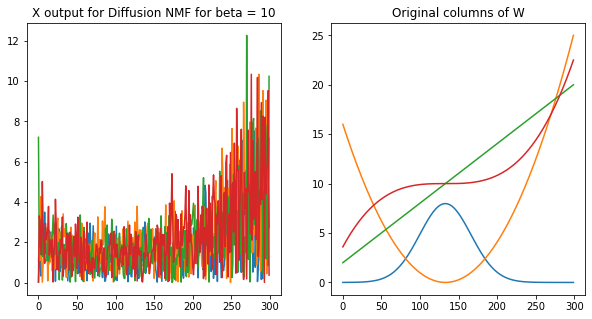

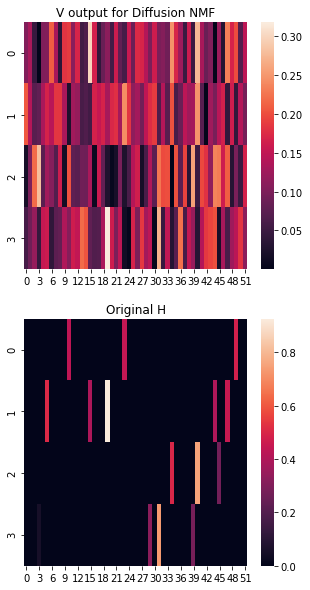

Diffusion X error on W: 277.5227585168613
Diffusion V error on H: 2.47579224626368
Diffusion error on D: 2.0892354540492604



In [30]:
diffn_plot(W,H,L, [1,3,10])

### State adjacency Laplacian

In [31]:
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()

In [32]:
np.trace(state_L)

218

K Condition Number : 10.95709432694549


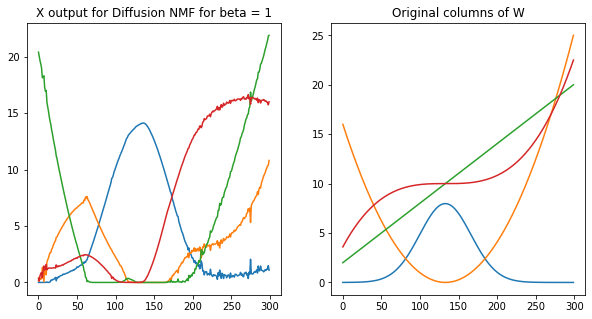

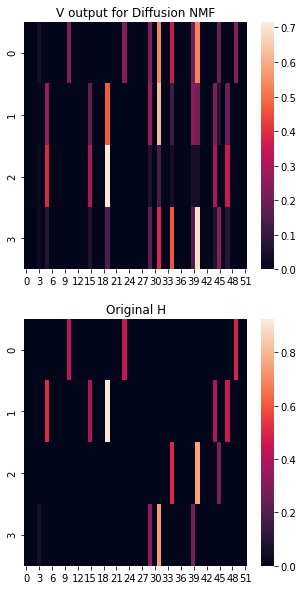

Diffusion X error on W: 226.02708174048584
Diffusion V error on H: 2.1691283453128176
Diffusion error on D: 2.0529054170081764

K Condition Number : 30.871282980836465


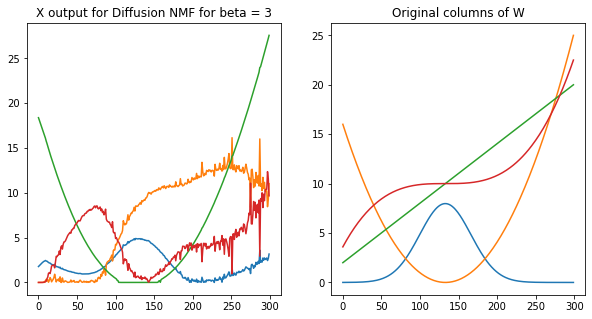

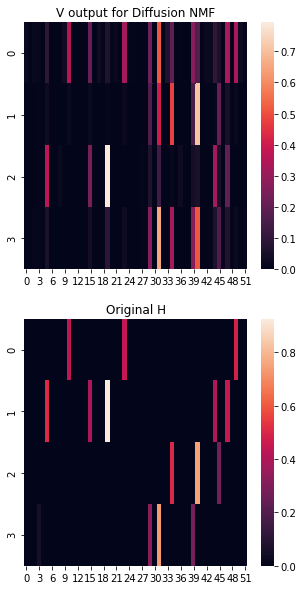

Diffusion X error on W: 235.44286072246362
Diffusion V error on H: 2.32687375336207
Diffusion error on D: 3.3108404165833596

K Condition Number : 100.57094326945528


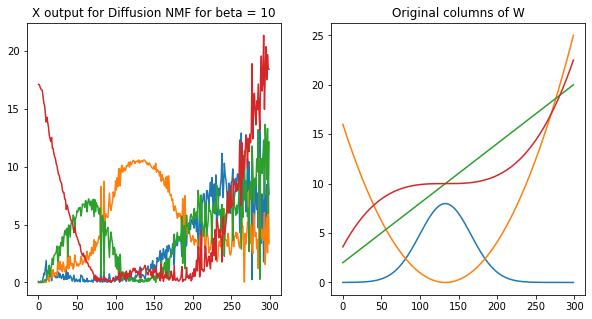

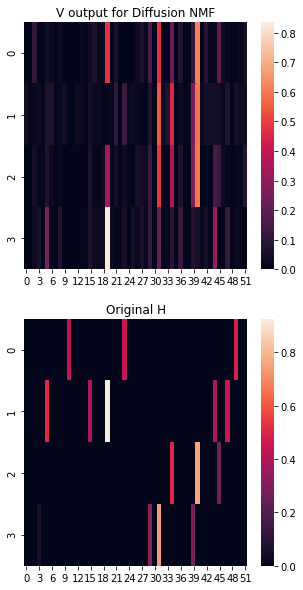

Diffusion X error on W: 271.22078286606575
Diffusion V error on H: 2.4266779931820612
Diffusion error on D: 3.7243225671033504



In [33]:
diffn_plot(W,H,state_L, [1,3,10])

## Trying to use multiple beta values

In [78]:
adj_L = L.copy()

In [79]:
adj_L

array([[17., -1.,  0., ..., -1., -1., -1.],
       [-1., 11.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 14., ...,  0.,  0.,  0.],
       ...,
       [-1.,  0.,  0., ..., 14.,  0.,  0.],
       [-1.,  0.,  0., ...,  0., 12.,  0.],
       [-1.,  0.,  0., ...,  0.,  0., 12.]])

In [80]:
corrs = np.corrcoef(H, rowvar = False)
for i in range(adj_L.shape[0]):
    for j in range(adj_L.shape[1]):
        if i == j:
            break
        else:
            col_dist = np.linalg.norm(H.loc[:,i] - H.loc[:,j])
            col_corr = corrs[i][j]
            adj_dist = col_dist
            if not np.isnan(col_corr):#col_dist != 0:
                adj_L[i][j] -= adj_dist
                adj_L[j][i] -= adj_dist
                adj_L[i][i] += adj_dist
                adj_L[j][j] += adj_dist
                

In [82]:
Kr = np.linalg.inv(I + 1 * adj_L)
Dr = np.dot(W, np.dot(H, Kr))

In [83]:
np.linalg.cond(Kr)

32.57997120125497

In [84]:
diff_vect = DiffusionNMF(Dr, Kr, ncomponents = 4, sparseV = None, sparseX = None, iterations = 1000, tol = 1e-200)
diff_vect.solver()
drx = pd.DataFrame(diff_vect.X)
drv = pd.DataFrame(diff_vect.V)

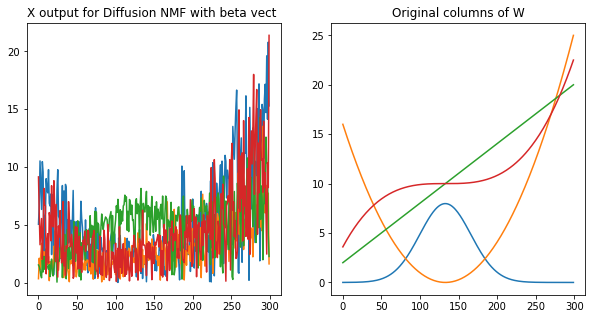

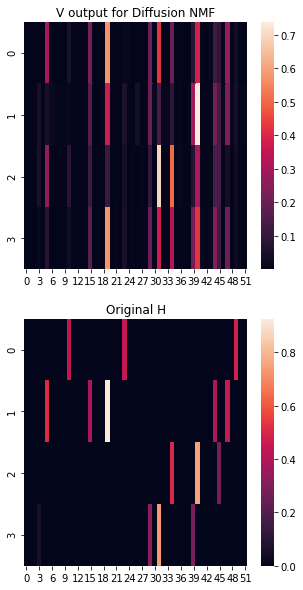

Diffusion X error on W: 246.95005409082916
Diffusion V error on H: 2.1649413189776734
Diffusion error on D: 4.299638209493042



In [85]:
fix, ax = plt.subplots(1, 2, figsize = (10,5))
for col in drx:
    ax[0].plot(drx.loc[:,col])
    ax[1].plot(W.loc[:,col])

    ax[0].set_title("X output for Diffusion NMF with beta vect ")
    ax[1].set_title("Original columns of W")
plt.show()

fig, ax = plt.subplots(2, 1, figsize = (5,10))
seaborn.heatmap(drv, square = False, cbar = True, ax = ax[0])
ax[0].set_title("V output for Diffusion NMF")
seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Original H")
plt.show()

print("Diffusion X error on W:", np.linalg.norm(W - drx))
print("Diffusion V error on H:", np.linalg.norm(H - drv))
print("Diffusion error on D:", np.linalg.norm(Dr - np.dot(drx, np.dot(drv, Kr))))
print()